In [3]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

In [4]:
def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

In [5]:
def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)

In [6]:
def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove the black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation

In [7]:
def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

In [8]:
def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar

In [9]:
def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()

In [10]:
# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
image = imutils.url_to_image(
    "https://3.bp.blogspot.com/-7dx2m8gTp4U/WRbdfZelCWI/AAAAAAAAADA/YykWebUW0PokPPHHcQTilD3NipawQfC4ACK4B/w1200-h630-p-k-no-nu/Fan%2BBingbing%2Bprofile%2Bfamily%252C%2Bwiki%2BAge%252C%2BAffairs%252C%2BBiodata%252C%2BHusband%252C%2BHeight%252C%2BWeight%252C%2BBiography%2Bgo%2Bprofile%2B2.jpg")

# Resize image to a width of 250
image = imutils.resize(image, width=250)

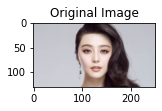

In [11]:
# Show image
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

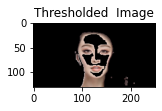

In [12]:
skin = extractSkin(image)
plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
plt.show()

In [13]:
# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

Color Information
{'cluster_index': 2,
 'color': [222.24678456591653, 193.00401929260468, 181.0803858520894],
 'color_percentage': 0.2683926645091694}

{'cluster_index': 0,
 'color': [194.50691244239647, 161.06912442396302, 147.85990783410108],
 'color_percentage': 0.2343042071197411}

{'cluster_index': 4,
 'color': [163.825997952917, 129.9815762538384, 114.29887410440091],
 'color_percentage': 0.21100323624595468}

{'cluster_index': 1,
 'color': [130.6906474820144, 99.51366906474813, 86.75827338129491],
 'color_percentage': 0.1505933117583603}

{'cluster_index': 3,
 'color': [76.77602523659303, 55.23028391167197, 53.160883280757076],
 'color_percentage': 0.13570658036677455}



Color Bar


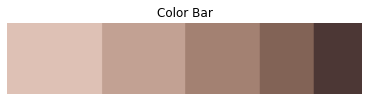

In [14]:
# Show in the dominant color as bar
print("Color Bar")
color_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(color_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()

In [15]:
example = dominantColors[0]['color']
example

[222.24678456591653, 193.00401929260468, 181.0803858520894]

In [11]:
import colorsys
colorsys.rgb_to_hsv(222,193,181)

(0.048780487804878, 0.18468468468468466, 0.8705882352941177)

In [28]:
import pickle
import joblib

In [29]:
filename = 'finalized_model.sav'
joblib.dump(extractDominantColor, filename)

['finalized_model.sav']

In [30]:
# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
image = imutils.url_to_image(
    "https://3.bp.blogspot.com/-7dx2m8gTp4U/WRbdfZelCWI/AAAAAAAAADA/YykWebUW0PokPPHHcQTilD3NipawQfC4ACK4B/w1200-h630-p-k-no-nu/Fan%2BBingbing%2Bprofile%2Bfamily%252C%2Bwiki%2BAge%252C%2BAffairs%252C%2BBiodata%252C%2BHusband%252C%2BHeight%252C%2BWeight%252C%2BBiography%2Bgo%2Bprofile%2B2.jpg")

# Resize image to a width of 250
image = imutils.resize(image, width=250)

In [32]:
loaded_model = joblib.load(filename)
result = loaded_model(image)
print(result)

[{'cluster_index': 3, 'color': [199.67531683765947, 198.72057936028827, 205.14553641892118], 'color_percentage': 0.657618320610687}, {'cluster_index': 4, 'color': [39.849318344894556, 24.05046639559845, 29.528581679024086], 'color_percentage': 0.12803053435114503}, {'cluster_index': 2, 'color': [166.29411764705875, 136.45667726550096, 124.24244833068377], 'color_percentage': 0.07685496183206107}, {'cluster_index': 0, 'color': [238.8567005749672, 217.48562582927954, 209.48518354710296], 'color_percentage': 0.06903816793893129}, {'cluster_index': 1, 'color': [81.91737005775246, 64.40648600622002, 65.46645935139944], 'color_percentage': 0.06845801526717557}]
